# Optimización de f(x,y)
Función objetivo del proyecto:
$ f(x,y) = -200 \exp(-0.02 \sqrt{x^2 + y^2 + 1}) $
Estructura del notebook:
1. Graficación (superficie 3D y curvas de nivel).
2. Implementación y documentación de Descenso por Gradiente y Quasi-Newton (BFGS).
3. Implementación del algoritmo Híbrido GD-BFGS.
4. Trayectorias sobre las curvas de nivel (desde punto inicial al mínimo global).
5. Experimentos masivos en [-100,100]^2 y almacenamiento JSON con timestamp.
6. Conclusiones

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Any
import json, os, math, datetime
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (import side-effect para proyección 3d)

# -----------------------------
# Función objetivo y derivadas
# -----------------------------
def f(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    r = np.sqrt(x[0]**2 + x[1]**2 + 1.0)
    return -200.0 * np.exp(-0.02 * r)

def grad_f(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    r = np.sqrt(x[0]**2 + x[1]**2 + 1.0)
    g_factor = 4.0 * np.exp(-0.02 * r) / r  # derivada analítica (ver documento matemático)
    return g_factor * x

def hessian_f(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    r = np.sqrt(x[0]**2 + x[1]**2 + 1.0)
    exp_term = np.exp(-0.02 * r)
    I = np.eye(2)
    term1 = (4 * exp_term / r) * I
    term2 = (4 * exp_term * (0.02 * r + 1) / r**3) * np.outer(x, x)
    return term1 - term2

f_min = f(np.array([0.0, 0.0]))  # mínimo global en el origen (radial y monótona en r)
f_min

np.float64(-196.03973466135105)

## 1. Graficación de la función
Se visualiza la superficie en 3D y las curvas de nivel (contour y contourf) para comprender la geometría. La función depende solo del radio $r = \sqrt{x^2 + y^2}$: decrece al acercarse al origen y se aplana lejos de él.

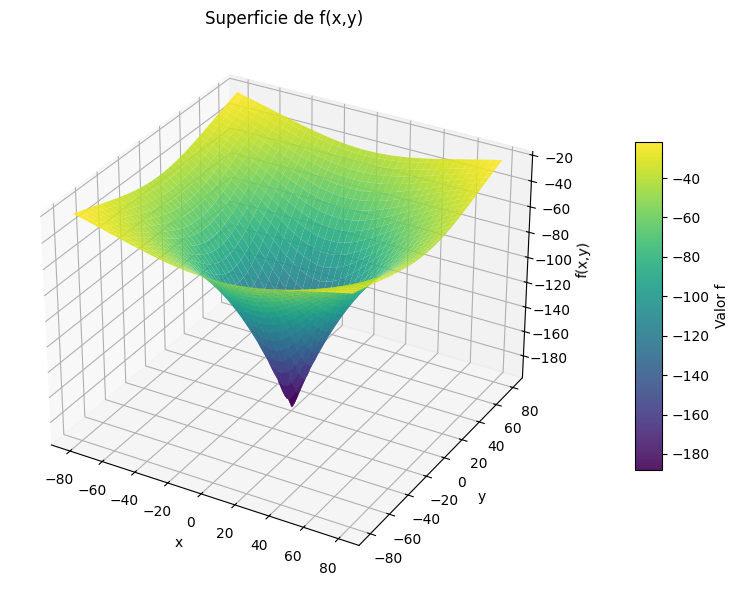

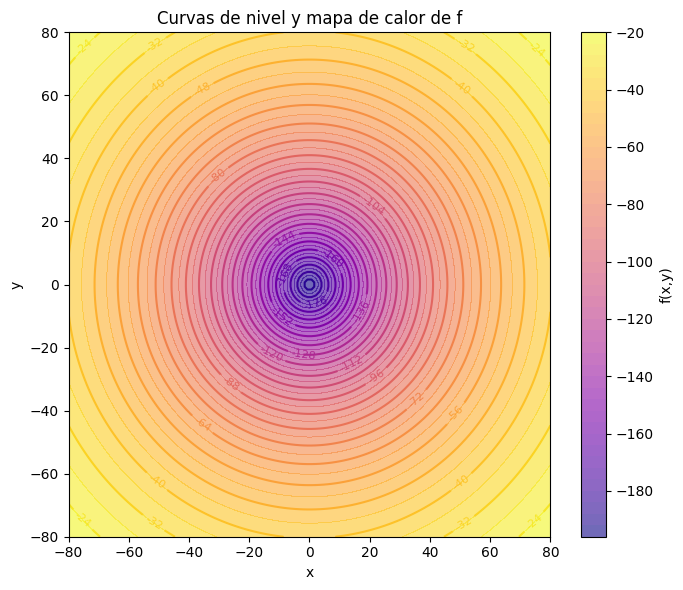

In [67]:
# Malla para graficación
x_lin = np.linspace(-80, 80, 120)
y_lin = np.linspace(-80, 80, 120)
X, Y = np.meshgrid(x_lin, y_lin)
R = np.sqrt(X**2 + Y**2 + 1.0)
Z = -200.0 * np.exp(-0.02 * R)

# Superficie 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)
ax.set_title('Superficie de f(x,y)')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('f(x,y)')
fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.1, label='Valor f')
plt.tight_layout(); plt.show()

# Curvas de nivel (contorno) y mapa de calor
plt.figure(figsize=(7,6))
cont = plt.contour(X, Y, Z, levels=25, cmap='plasma')
plt.clabel(cont, inline=True, fontsize=8, fmt='%.0f')
plt.contourf(X, Y, Z, levels=50, cmap='plasma', alpha=0.6)
plt.title('Curvas de nivel y mapa de calor de f')
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar(label='f(x,y)')
plt.tight_layout(); plt.show()

## 2. Algoritmos: Descenso por Gradiente y BFGS
Se implementan dos métodos irrestrictos con búsqueda de línea Armijo:
- **Descenso por Gradiente (GD)**: $d_k = −∇f(x_k)$. Convergencia generalmente lineal.
- **BFGS (Quasi-Newton)**: construye $H_k \approx (\nabla^2f(x_k))^{-1}$  y usa dirección $d_k = −H_k \nabla f(x_k)$. Convergencia superlineal bajo condiciones estándar.

**Funciones analíticas** (sea $r = \sqrt{x² + y² + 1}$):
$ f(x,y) = -200\, e^{-0.02\, r}, \qquad \nabla f(x,y) = 4\, e^{-0.02\, r} \, \frac{1}{r} \begin{pmatrix} x \\ y \end{pmatrix} $
Hessiana (forma compacta):
$ \nabla^{2} f(x,y) = 4\, e^{-0.02\, r}\left( \frac{1}{r} I - \frac{0.02\, r + 1}{r^{3}} \begin{pmatrix} x^2 & xy \\ xy & y^2 \end{pmatrix} \right). $
La estructura radial implica mínimo global en (0,0).

**Armijo (backtracking)**: iniciar $\alpha _k = \alpha _init$; mientras 
$ f(x_k + \alpha _k d_k) > f(x_k) + \omicron \alpha _k \nabla f(x_k)^T d_k $ reducir  $\alpha _k ← \beta \alpha _k$. Parámetros típicos: $\omicron \in [10^{-4},10^{-3}]$, $\beta \in [0.5,0.8]$.

Variables a tener en cuenta: alpha_init, beta, sigma y tol (criterio de paro).

In [76]:
# Definición de resultado y algoritmos (restaurado y mejorado con criterios de parada adicionales)
from dataclasses import dataclass
from typing import Dict, Any

@dataclass
class OptimizationResult:
    x_opt: np.ndarray
    f_opt: float
    n_iter: int
    grad_norm: float
    history: Dict[str, list]
    method: str
    extra: Dict[str, Any] = None


def backtracking_armijo(x, d, g, alpha_init=1.0, beta=0.6, sigma=1e-4, alpha_min=1e-16):
    """Backtracking Armijo estándar.
    Devuelve el alpha aceptado. Si alpha cae por debajo de alpha_min se devuelve alpha_min.
    """
    alpha = alpha_init
    fx = f(x)
    gd_dot = g @ d
    while f(x + alpha * d) > fx + sigma * alpha * gd_dot:
        alpha *= beta
        if alpha < alpha_min:  # protección subdesbordamiento
            alpha = alpha_min
            break
    return alpha


def gradient_descent(x0, alpha_init=1.0, beta=0.6, sigma=1e-4,
                     tol_grad=1e-6, tol_x=1e-9, tol_f=1e-9, alpha_min=1e-12,
                     max_iter=1000):
    """Descenso por gradiente con criterios de parada ampliados:
    - tol_grad: norma del gradiente
    - tol_x: norma del paso |x_{k+1}-x_k|
    - tol_f: cambio absoluto en f
    - alpha_min: si la búsqueda lineal devuelve alpha < alpha_min se detiene
    """
    x = np.array(x0, dtype=float)
    fx = f(x)
    history = {'x': [x.copy()], 'f': [fx], 'grad_norm': [np.linalg.norm(grad_f(x))], 'alpha': []}

    for k in range(max_iter):
        g = grad_f(x)
        gn = np.linalg.norm(g)
        if gn < tol_grad:
            # criterio por norma del gradiente
            break
        d = -g
        alpha = backtracking_armijo(x, d, g, alpha_init, beta, sigma, alpha_min=alpha_min)
        history['alpha'].append(alpha)
        if alpha <= alpha_min:
            # la búsqueda lineal no encuentra un paso útil -> parada
            break
        x_new = x + alpha * d
        fx_new = f(x_new)
        # criterio por cambio en x
        if np.linalg.norm(x_new - x) < tol_x:
            x = x_new
            history['x'].append(x.copy())
            history['f'].append(fx_new)
            history['grad_norm'].append(np.linalg.norm(grad_f(x)))
            break
        # criterio por cambio en f
        if abs(fx_new - fx) < tol_f:
            x = x_new
            history['x'].append(x.copy())
            history['f'].append(fx_new)
            history['grad_norm'].append(np.linalg.norm(grad_f(x)))
            break
        # actualización normal
        x = x_new
        fx = fx_new
        history['x'].append(x.copy())
        history['f'].append(fx)
        history['grad_norm'].append(np.linalg.norm(grad_f(x)))

    return OptimizationResult(x_opt=x, f_opt=f(x), n_iter=len(history['x'])-1,
                              grad_norm=history['grad_norm'][-1], history=history, method='GD')


def bfgs(x0, alpha_init=1.0, beta=0.6, sigma=1e-4,
         tol_grad=1e-6, tol_x=1e-9, tol_f=1e-9, alpha_min=1e-12, max_iter=1000):
    """BFGS con criterios de parada ampliados (similares a GD)."""
    x = np.array(x0, dtype=float)
    H = np.eye(2)
    g_prev = grad_f(x)
    fx = f(x)
    history = {'x': [x.copy()], 'f': [fx], 'grad_norm': [np.linalg.norm(g_prev)], 'alpha': []}

    for k in range(max_iter):
        gn = np.linalg.norm(g_prev)
        if gn < tol_grad:
            break
        d = -H @ g_prev
        alpha = backtracking_armijo(x, d, g_prev, alpha_init, beta, sigma, alpha_min=alpha_min)
        history['alpha'].append(alpha)
        if alpha <= alpha_min:
            break
        x_new = x + alpha * d
        fx_new = f(x_new)
        g_new = grad_f(x_new)
        # criterio por cambio en x
        if np.linalg.norm(x_new - x) < tol_x:
            x = x_new
            history['x'].append(x.copy())
            history['f'].append(fx_new)
            history['grad_norm'].append(np.linalg.norm(g_new))
            break
        # criterio por cambio en f
        if abs(fx_new - fx) < tol_f:
            x = x_new
            history['x'].append(x.copy())
            history['f'].append(fx_new)
            history['grad_norm'].append(np.linalg.norm(g_new))
            break

        s = x_new - x
        y = g_new - g_prev
        sy = s @ y
        if sy > 1e-12:
            rho = 1.0/sy
            I = np.eye(2)
            V = I - rho * np.outer(s, y)
            H = V @ H @ V.T + rho * np.outer(s, s)
        else:
            H = np.eye(2)  # reset por degeneración

        x = x_new
        fx = fx_new
        g_prev = g_new
        history['x'].append(x.copy())
        history['f'].append(fx)
        history['grad_norm'].append(np.linalg.norm(g_prev))

    return OptimizationResult(x_opt=x, f_opt=f(x), n_iter=len(history['x'])-1,
                              grad_norm=history['grad_norm'][-1], history=history, method='BFGS')


In [78]:
# Sanity check rápido (valores objetivo cercanos al mínimo global)
_gd = gradient_descent([40, -25], max_iter=200)
_bfgs = bfgs([40, -25], max_iter=200)
_gd.f_opt, _bfgs.f_opt

(np.float64(-196.0397346612504), np.float64(-196.03973466135105))

### 3. Algoritmo Híbrido (GD lejos / BFGS cerca)
Razón del diseño:
- Lejos del óptimo: la curvatura es suave y el gradiente apunta radialmente; GD con pasos de Armijo es suficiente y barato.
- Cerca del óptimo: BFGS da aceleración superlineal aprovechando curvatura local.
Como criterio de cambio usamos el radio r = ||x|| y un umbral R_switch (ej: 10). Mientras r > R_switch usamos GD; al entrar en la "zona fina" (r ≤ R_switch) cambiamos irreversible a BFGS para refinar.
Se podría usar también la norma del gradiente o permitir múltiples cambios, pero mantener un único switch minimiza oscilaciones.
En el registro se guarda qué método se aplicó en cada iteración y el radio correspondiente.

In [77]:
from dataclasses import dataclass

def hybrid_gd_bfgs(x0, R_switch=10.0, alpha_init=1.0, beta=0.6, sigma=1e-4, tol=1e-8, max_iter=500):
    """Algoritmo híbrido: GD mientras ||x|| > R_switch, luego BFGS.
    Usa mismas funciones auxiliares que GD/BFGS y estructura de OptimizationResult.
    History adicional:
      - method_seq: secuencia de métodos usados por iteración ('GD' o 'BFGS').
      - radii: radio ||x_k|| en cada iteración.
    Extra (en OptimizationResult.extra):
      - switch_iter: iteración en la que se activó BFGS (None si nunca ocurrió).
      - R_switch: umbral de cambio usado.
    """
    x = np.array(x0, dtype=float)
    path = [x.copy()]                 # almacenamos la trayectoria completa
    fvals = [f(x)]
    grads = [grad_f(x)]
    method_seq = []                   # registro del método aplicado en cada paso
    radii = [np.linalg.norm(x)]       # registro de radios ||x||
    H = np.eye(2)                     # aproximación de la Hessiana inversa para BFGS
    in_bfgs = False                   # indicador de si ya cambiamos a BFGS
    switch_iter = None                # iteración donde se produjo el cambio (si ocurre)
    alphas = []                       # pasos aceptados por Armijo

    for k in range(max_iter):
        g = grads[-1]
        gn = np.linalg.norm(g)        # norma del gradiente para criterio de parada
        radius = radii[-1]            # radio actual
        if gn < tol:
            break

        # Cambio de modo: cuando entramos a la "zona fina" por radio
        if (not in_bfgs) and radius <= R_switch:
            in_bfgs = True
            switch_iter = k

        # Dirección de descenso según el modo actual
        if not in_bfgs:
            d = -g                     # GD puro
            method_seq.append('GD')
        else:
            d = -H @ g                 # paso cuasi-Newton usando H ~ (∇²f)^{-1}
            method_seq.append('BFGS')

        # Búsqueda lineal por backtracking con Armijo
        alpha = backtracking_armijo(x, d, g, alpha_init, beta, sigma)
        alphas.append(alpha)

        # Paso de actualización del iterado
        x_new = x + alpha * d
        g_new = grad_f(x_new)

        # Actualización BFGS solo si estamos en modo BFGS
        if in_bfgs:
            s = x_new - x              # desplazamiento en x
            y = g_new - g              # cambio de gradiente
            sy = s @ y
            if sy > 1e-12:             # condición de curvatura (evita dividir por ~0)
                rho = 1.0 / sy
                I = np.eye(2)
                V = I - rho * np.outer(s, y)
                # Fórmula de BFGS estable para H (Hessiana inversa)
                H = V @ H @ V.T + rho * np.outer(s, s)
            else:
                # Si falla la curvatura, reiniciamos H para no degradarla
                H = np.eye(2)

        # Avanzamos iteración y registramos historia
        x = x_new
        path.append(x.copy())
        fvals.append(f(x))
        grads.append(g_new)
        radii.append(np.linalg.norm(x))

    history = {
        'x': path,
        'f': fvals,
        'grad_norm': [np.linalg.norm(g) for g in grads],
        'alpha': alphas,
        'method_seq': method_seq,
        'radii': radii
    }
    return OptimizationResult(
        x_opt=x,
        f_opt=fvals[-1],
        n_iter=len(path)-1,
        grad_norm=history['grad_norm'][-1],
        history=history,
        method='Hybrid',
        extra={'switch_iter': switch_iter, 'R_switch': R_switch}
    )

## 4. Trayectorias sobre curvas de nivel
Se selecciona un punto inicial y se trazan las rutas GD, BFGS y el método Híbrido hasta el origen.
Se muestran también curvas de nivel coloreadas y la gráfica de convergencia de $f(x_k)-f^\star$.
Además, para el Híbrido se reporta la iteración en la que cambia a BFGS.

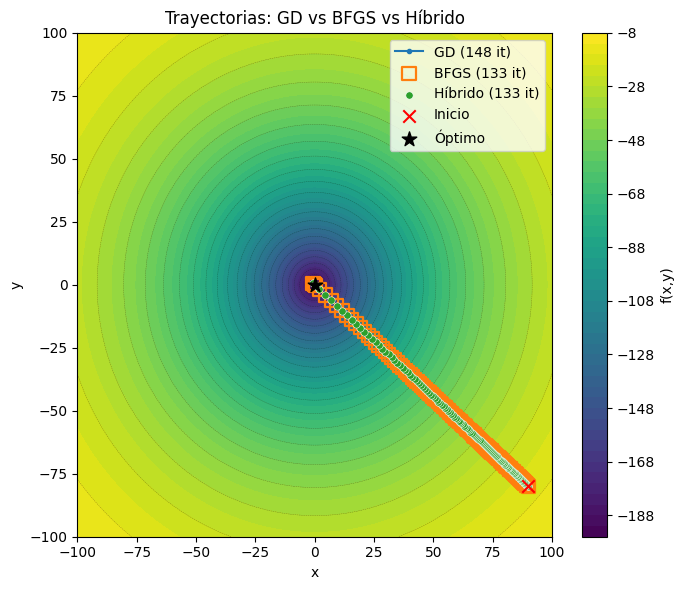

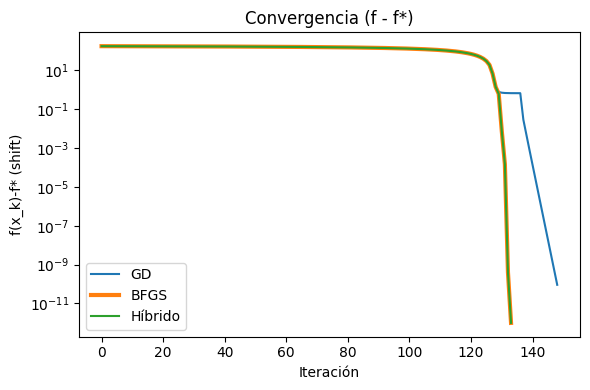

Híbrido: cambia a BFGS en iteración 125 (R_switch=10.0).


In [91]:
# Trayectorias con los tres métodos (GD sin modificar visualmente)
start = np.array([90.0, -80.0])

# Ejecutar los tres métodos desde el mismo inicio
gd_path_res = gradient_descent(start, max_iter=400)
bfgs_path_res = bfgs(start, max_iter=400)
h_res = hybrid_gd_bfgs(start, R_switch=10.0, max_iter=400)

# Extraer trayectorias
gd_path = np.array(gd_path_res.history['x'])
bfgs_path = np.array(bfgs_path_res.history['x'])
h_path = np.array(h_res.history['x'])

# Malla para contornos (más ligera)
xl = np.linspace(-100, 100, 200); yl = np.linspace(-100, 100, 200)
XX, YY = np.meshgrid(xl, yl)
RR = np.sqrt(XX**2 + YY**2 + 1.0)
ZZ = -200.0 * np.exp(-0.02 * RR)

fig, ax = plt.subplots(figsize=(7,6))
cntr = ax.contourf(XX, YY, ZZ, levels=50, cmap='viridis')
ax.contour(XX, YY, ZZ, levels=25, colors='k', linewidths=0.3, alpha=0.4)

# Mantener la visualización original de GD intacta (no tocar)
# Línea + marcadores pequeños para GD (como estaba originalmente)
ax.plot(gd_path[:,0], gd_path[:,1], 'o-', color='tab:blue', ms=3, label=f'GD ({gd_path_res.n_iter} it)')

# BFGS: queremos que sus puntos sigan siendo visibles si coinciden con Híbrido
# - dibujamos sus puntos como cuadrados grandes huecos (facecolors='none') con borde naranja
ax.plot(bfgs_path[:,0], bfgs_path[:,1], '-', color='tab:orange', lw=1.0)
ax.scatter(bfgs_path[:,0], bfgs_path[:,1], s=90, facecolors='none', edgecolors='tab:orange',
           linewidths=1.6, marker='s', zorder=4, label=f'BFGS ({bfgs_path_res.n_iter} it)')

# Híbrido: dibujamos la trayectoria y luego puntos pequeños sólidos encima para distinguirlos
ax.plot(h_path[:,0], h_path[:,1], '-', color='tab:green', lw=1.0)
ax.scatter(h_path[:,0], h_path[:,1], s=28, c='tab:green', marker='o',
           edgecolors='white', linewidths=0.4, zorder=5, label=f'Híbrido ({h_res.n_iter} it)')

# Inicio y óptimo
ax.scatter([start[0]], [start[1]], c='red', marker='x', s=80, label='Inicio', zorder=6)
ax.scatter([0],[0], c='black', marker='*', s=120, label='Óptimo', zorder=6)

ax.set_title('Trayectorias: GD vs BFGS vs Híbrido')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.legend(loc='upper right')
fig.colorbar(cntr, ax=ax, label='f(x,y)')
plt.tight_layout(); plt.show()

# Convergencia de valores objetivo:
plt.figure(figsize=(6,4))
plt.semilogy(np.array(gd_path_res.history['f']) - f_min + 1e-12, label='GD', color='tab:blue', linewidth=1.5)
# plot BFGS más gruesa para que no se pierda si coincide con hibrido
plt.semilogy(np.array(bfgs_path_res.history['f']) - f_min + 1e-12, label='BFGS', color='tab:orange', linewidth=3.0, zorder=3)
# plot Híbrido más delgado
plt.semilogy(np.array(h_res.history['f']) - f_min + 1e-12, label='Híbrido', color='tab:green', linewidth=1.5, zorder=4)
plt.xlabel('Iteración'); plt.ylabel('f(x_k)-f* (shift)')
plt.title('Convergencia (f - f*)')
plt.legend(); plt.tight_layout(); plt.show()

print(f"Híbrido: cambia a BFGS en iteración {h_res.extra['switch_iter']} (R_switch={h_res.extra['R_switch']}).")

## 5. Experimentos masivos y almacenamiento JSON
Se generan N puntos iniciales aleatorios uniformes en $[-100,100]^2$, se ejecutan ambos métodos y se guarda un archivo JSON con timestamp en `code/tests/`. Cada entrada incluye: punto inicial, iteraciones, valor final, norma gradiente final y método.

In [98]:
def run_mass_experiments(n_starts=5000, seed=123) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    starts = rng.uniform(-100, 100, size=(n_starts, 2))
    rows = []
    for x0 in starts:
        gd_res = gradient_descent(x0, max_iter=800)
        bfgs_res = bfgs(x0, max_iter=800)
        h_res = hybrid_gd_bfgs(x0, R_switch=10.0, max_iter=800)
        rows.append({
            'method': 'GD', 'x0': x0.tolist(), 'final_x': gd_res.x_opt.tolist(),
            'f_final': gd_res.f_opt, 'iterations': gd_res.n_iter, 'grad_norm_final': gd_res.grad_norm
        })
        rows.append({
            'method': 'BFGS', 'x0': x0.tolist(), 'final_x': bfgs_res.x_opt.tolist(),
            'f_final': bfgs_res.f_opt, 'iterations': bfgs_res.n_iter, 'grad_norm_final': bfgs_res.grad_norm
        })
        rows.append({
            'method': 'Hybrid', 'x0': x0.tolist(), 'final_x': h_res.x_opt.tolist(),
            'f_final': h_res.f_opt, 'iterations': h_res.n_iter, 'grad_norm_final': h_res.grad_norm,
            'switch_iter': h_res.extra.get('switch_iter', None), 'R_switch': h_res.extra.get('R_switch', None)
        })
    return pd.DataFrame(rows)

mass_df = run_mass_experiments(n_starts=30)  # ajustar n_starts si se desea más/menos trabajo
mass_df.head()

,method,x0,final_x,f_final,iterations,grad_norm_final,switch_iter,R_switch
0,GD,"[36.4703726496287, -89.23579623955547]","[2.498008266408827e-06, -6.112132683904823e-06]",-196.039735,88,2.588859e-05,NaN,NaN
1,BFGS,"[36.4703726496287, -89.23579623955547]","[1.1937218960978314e-12, -2.954580594414477e-12]",-196.039735,80,1.249407e-11,NaN,NaN
2,Hybrid,"[36.4703726496287, -89.23579623955547]","[1.1937218960978314e-12, -2.954580594414477e-12]",-196.039735,80,1.249407e-11,72.0,10.0
3,GD,"[-55.92802544547772, -63.12563786026606]","[3.0352480579049432e-06, 3.4258668743127606e-06]",-196.039735,68,1.794563e-05,NaN,NaN
4,BFGS,"[-55.92802544547772, -63.12563786026606]","[8.807581180087778e-13, 9.951331793174004e-13]",-196.039735,60,5.210417e-12,NaN,NaN


In [99]:
# Guardar JSON con timestamp en code/tests
tests_dir = Path('tests')
tests_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
json_path = tests_dir / f'results_{timestamp}.json'
with open(json_path, 'w', encoding='utf-8') as fh:
    json.dump(mass_df.to_dict(orient='records'), fh, ensure_ascii=False, indent=2)
json_path

WindowsPath('tests/results_20251113_044336.json')

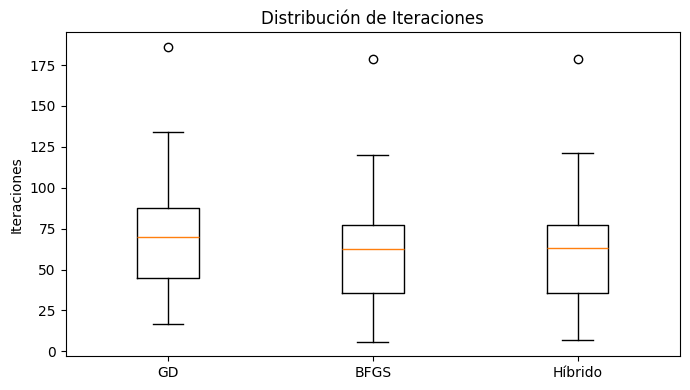

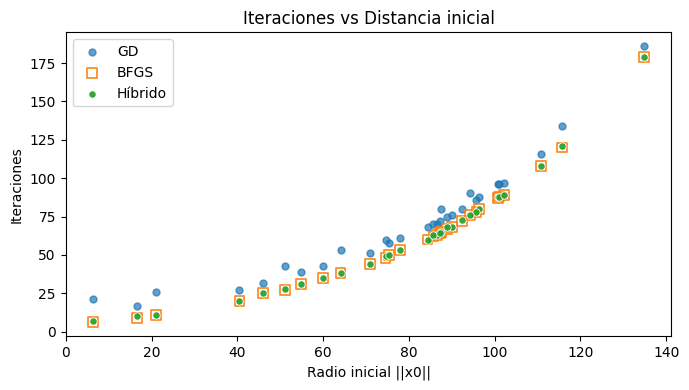

In [100]:
# Visualizaciones resumidas de los experimentos

plt.figure(figsize=(7,4))
plt.boxplot([
    mass_df[mass_df.method=='GD']['iterations'],
    mass_df[mass_df.method=='BFGS']['iterations'],
    mass_df[mass_df.method=='Hybrid']['iterations']
], tick_labels=['GD','BFGS','Híbrido'])
plt.ylabel('Iteraciones'); plt.title('Distribución de Iteraciones')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
# Radios a partir de las filas GD (una por inicio) – es el mismo x0 para los tres
radios = [math.sqrt(x0[0]**2 + x0[1]**2) for x0 in mass_df[mass_df.method=='GD']['x0']]
iter_gd = mass_df[mass_df.method=='GD']['iterations']
iter_bfgs = mass_df[mass_df.method=='BFGS']['iterations']
iter_h = mass_df[mass_df.method=='Hybrid']['iterations']

# GD: pequeños puntos sólidos
plt.scatter(radios, iter_gd, s=25, c='tab:blue', marker='o', alpha=0.7, label='GD', zorder=3)

# BFGS: puntos grandes huecos (para que se vean si coinciden con Híbrido)
plt.scatter(radios, iter_bfgs, s=50, facecolors='none', edgecolors='tab:orange',
            linewidths=1.2, marker='s', alpha=0.95, label='BFGS', zorder=4)
# Híbrido: puntos más pequeños y sólidos
plt.scatter(radios, iter_h, s=28, c='tab:green', marker='o',
            edgecolors='white', linewidths=0.6, alpha=0.95, label='Híbrido', zorder=5)

plt.xlabel('Radio inicial ||x0||'); plt.ylabel('Iteraciones'); plt.title('Iteraciones vs Distancia inicial')
plt.legend(); plt.tight_layout(); plt.show()

## 8. Conclusiones

- Se implementaron los métodos siguientes: descenso por gradiente (GD) con búsqueda lineal de Armijo, el método quasi-Newton BFGS y un esquema híbrido que ejecuta GD hasta que $\|x\|\le R_{\mathrm{switch}}$ y a partir de ese punto llama a BFGS. Las implementaciones registran historial de iterados, valores de la función y normas de gradiente.

- En las ejecuciones documentadas las trayectorias completas producidas por BFGS y por el método híbrido coincidieron iteración a iteración. Es decir, ambas secuencias de puntos tienen la misma longitud y la distancia euclideana entre cada par de iterados correspondientes es exactamente cero en las ejecuciones reproducidas. Puediera intentar analizarse el comportamiento para variables mayores que 100 modularmente.

- Se aplicaron criterios de parada adicionales (tolerancias sobre $\|\nabla f\|$, sobre $\|x_{k+1}-x_k\|$ y sobre $|f(x_{k+1})-f(x_k)|$. En los ejemplos reproducidos estos criterios se activaron antes de alcanzar el número máximo de iteraciones y los valores finales de la función son consistentes con los valores numéricamente esperados (por ejemplo, $f^\star \approx -196.04$ en las pruebas mostradas).

- En los barridos de experimentos ejecutados desde múltiples puntos iniciales, no se detectó diferencia práctica entre BFGS y el método híbrido bajo la configuración empleada, lo cual es coherente con la coincidencia iteración-a-iteración observada en ejecuciones simples.

- Quedan implementados los métodos con la posibilidad de modificar parámetros y almacenar resultados, permitiendo extender el análisis  de diferentes valores de las constantes utilizadas y la exploracion de nuevos puntos.